In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# new_df_all_nopq_shuffled = pd.read_pickle("new_df_all_nopq_shuffled.pkl")

# # new_df_all_2pq_shuffled = pd.read_pickle("new_df_all_2pq_shuffled.pkl")

# new_df_all_25pq_shuffled = pd.read_pickle("new_df_all_25pq_shuffled.pkl")

# # new_df_all_jpsi4pi_sigma = pd.read_pickle("new_df_all_jpsi4pi_sigma.pkl")

# # new_df_jpsi4pi_sigma_filtered = pd.read_pickle("new_df_jpsi4pi_sigma_filtered.pkl")

# training_new_df_all_nopq_shuffled = pd.read_pickle("training_new_df_all_nopq_shuffled.pkl")

# new_df_all_anomalies_shuffled = pd.read_pickle("new_df_all_anomalies_shuffled.pkl")

In [2]:
PID_noexotica = pd.read_pickle("PID_noexotica.pkl")
PID_exotica = pd.read_pickle("PID_exotica.pkl")
PID_training = pd.read_pickle("PID_training.pkl")

In [3]:
X_new = PID_training[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
# # Extract mass separately
# mass = df['mass'].values
mass_new = PID_training['InvariantMass'].values
# # Create a train/test split
X_new_train, X_new_test, mass_new_train, mass_new_test = train_test_split(X_new, mass_new, test_size=0.05, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform training data, transform test data
X_new_train = scaler.fit_transform(X_new_train)
X_new_test = scaler.transform(X_new_test)

print(X_new_train.shape, X_new_test.shape)

(313500, 21) (16500, 21)


In [4]:
X_new

array([[ 2.        ,  2.45287312,  0.30946634, ..., 10.        ,
        10.        , 10.        ],
       [ 2.        ,  2.43210512,  0.22969999, ..., 10.        ,
        10.        , 10.        ],
       [ 2.        ,  1.07842789,  0.18517637, ..., 10.        ,
        10.        , 10.        ],
       ...,
       [ 2.        ,  1.96942464,  1.3736593 , ..., 10.        ,
        10.        , 10.        ],
       [ 2.        ,  1.77142802,  2.06207098, ..., 10.        ,
        10.        , 10.        ],
       [ 2.        ,  0.05387986,  8.32648706, ..., 10.        ,
        10.        , 10.        ]])

In [5]:
print(X_new_train.shape[0])

313500


In [6]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
# tf.debugging.set_log_device_placement(True)

TensorFlow version: 2.10.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU (if any)


In [8]:
# #------------------------------------------
# # 2. Define the Autoencoder Model
# #------------------------------------------

input_dim = X_new_train.shape[1]  # should be 6
encoding_dim = 11             # latent space dimension

# # Input layer
input_layer = Input(shape=(input_dim,))

# # Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# # Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # best, 185 epochs automatic stop

#------------------------------------------
# 3. Train the Autoencoder
#------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,
    restore_best_weights=True
)

history = autoencoder.fit(X_new_train, X_new_train, 
                          epochs=500,
                          # epochs=500,
                          batch_size=256,
                        #   batch_size=64,
                          shuffle=True,
                          validation_data=(X_new_test, X_new_test),
                          verbose=2,
                          callbacks=[early_stopping]
                         )

# with tf.device('/CPU:0'):
#     history = autoencoder.fit(X_train, X_train,
#                               epochs=500,
#                               batch_size=64,
#                               validation_data=(X_test, X_test),
#                               callbacks=[early_stopping],
#                               verbose=2)
#     print(f"Training stopped at epoch {len(history.history['loss'])}")

print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
1225/1225 - 2s - loss: 0.0038 - val_loss: 5.1547e-04 - 2s/epoch - 1ms/step
Epoch 2/500
1225/1225 - 1s - loss: 3.4641e-04 - val_loss: 2.2317e-04 - 1s/epoch - 833us/step
Epoch 3/500
1225/1225 - 1s - loss: 2.0020e-04 - val_loss: 1.7772e-04 - 990ms/epoch - 808us/step
Epoch 4/500
1225/1225 - 1s - loss: 1.5952e-04 - val_loss: 1.5109e-04 - 1s/epoch - 861us/step
Epoch 5/500
1225/1225 - 1s - loss: 1.3736e-04 - val_loss: 1.2845e-04 - 945ms/epoch - 772us/step
Epoch 6/500
1225/1225 - 1s - loss: 1.1931e-04 - val_loss: 1.1089e-04 - 845ms/epoch - 690us/step
Epoch 7/500
1225/1225 - 1s - loss: 1.0295e-04 - val_loss: 9.4950e-05 - 875ms/epoch - 714us/step
Epoch 8/500
1225/1225 - 1s - loss: 9.3862e-05 - val_loss: 8.7776e-05 - 876ms/epoch - 715us/step
Epoch 9/500
1225/1225 - 1s - loss: 8.8833e-05 - val_loss: 8.6941e-05 - 1s/epoch - 824us/step
Epoch 10/500
1225/1225 - 1s - loss: 8.6565e-05 - val_loss: 8.2839e-05 - 1s/epoch - 874us/step
Epoch 11/500
1225/1225 - 1s - loss: 8.4931e-05 - val_loss: 8

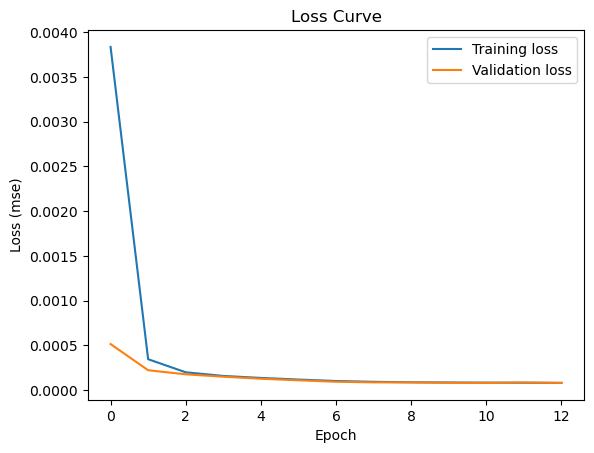

In [9]:
# Optional: Plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.title('Loss Curve')
plt.legend()
plt.savefig("final-loss2.pdf")
plt.show()

In [10]:
# #------------------------------------------
# # 4. Use the Autoencoder for Anomaly Detection
# #------------------------------------------

# # Compute reconstruction on the test set
X_new_test_pred = autoencoder.predict(X_new_test)
# # Calculate MSE per sample
mse = np.mean(np.power(X_new_test - X_new_test_pred, 2), axis=1)
#plot

# You need to define a threshold for what you consider "anomalous"
# This could be determined by analyzing the MSE distribution on training data, for example.
threshold = 0.01 #np.mean(mse) + 3*np.std(mse)  # Example heuristic

# Find anomalous events
anomalous_indices = np.where(mse > threshold)[0]

#------------------------------------------
# 5. Retrieve the Mass for Anomalous Events
#------------------------------------------

# For any anomalous event, we can now look up its mass
if len(anomalous_indices) > 0:
    print("Anomalous Event Indices:", anomalous_indices)
    print("Mass values for anomalous events:", mass_new_test[anomalous_indices])
else:
    print("No anomalies detected under this threshold.")


516/516 [==============================] - 0s 657us/step
No anomalies detected under this threshold.


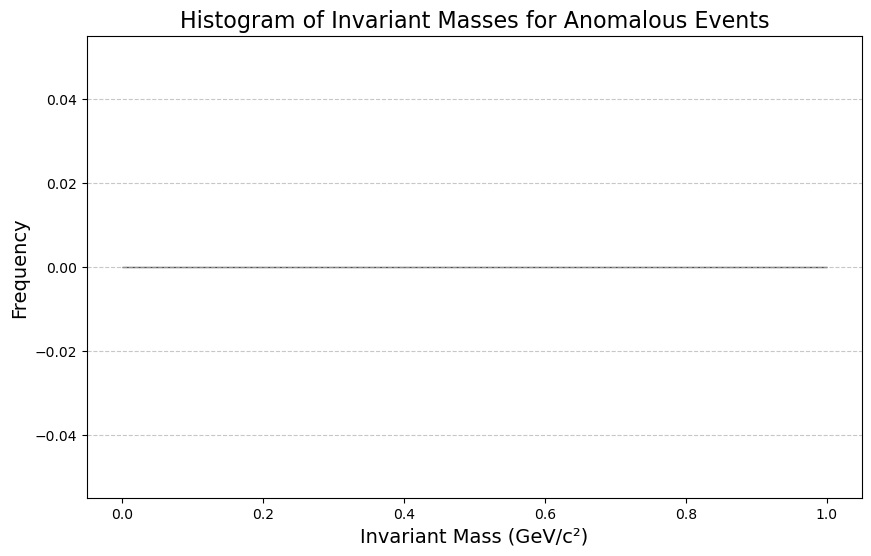

In [11]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(mass_new_test[anomalous_indices], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Invariant Masses for Anomalous Events', fontsize=16)
plt.xlabel('Invariant Mass (GeV/c²)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()

In [12]:
# print("\nReconstruction error for anomalous events (label 0):")
# print(mse)

# # Plot the distributions of reconstruction errors for normal and anomalous events

# plt.figure(figsize=(10, 6))
# plt.xscale('log')  # Log scale for x-axis
# plt.yscale('log')  # Log scale for y-axis
# # Plot reconstruction error for normal events
# # plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# # Plot reconstruction error for anomalous events
# # plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# # plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# # Add labels and title
# plt.hist(mse, bins=500, alpha=0.7, label="Normal Events", log=True, color = 'blue')  # Increase bins to 200 for finer binning and set log scale for y-axis
# #plt.xscale('log')  # Log scale for x-axis
# #plt.yscale('log')  # Log scale for y-axis
# plt.xlabel("Reconstruction error (log scale)")
# plt.ylabel("Number of events (log scale)")
# plt.title("Reconstruction Error Distribution")
# plt.show()

In [13]:
# new_anom = new_df_all_anomalies_shuffled[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
# # # Extract mass separately
# # mass = df['mass'].values
# mass_new_anom = new_df_all_anomalies_shuffled['InvariantMass'].values

# new_anom = scaler.transform(new_anom)

In [14]:
# new_df_all_anomalies_shuffled

In [15]:
# new_anom_pred = autoencoder.predict(new_anom)
# mse_new_anom = np.mean(np.power(new_anom - new_anom_pred, 2), axis=1)


In [16]:
# # Set the reconstruction error threshold
# mse_threshold = 0.01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# new_anom_high_mse_indices = mse_new_anom > mse_threshold  # Boolean mask for filtering
# new_anom_high_mse_masses = mass_new_anom[new_anom_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(new_anom_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} with 25 pentaquarks')
# plt.legend()

# # Show the plot
# plt.show()


In [17]:
# new_anom_high_mse_masses

In [18]:
# plt.figure(figsize=(10, 6))
# plt.xscale('log')  # Log scale for x-axis
# plt.yscale('log')  # Log scale for y-axis

# plt.hist(mse_new_anom, bins=50, alpha=0.7, label='Normal Events', color='blue')

# plt.xlabel('Reconstruction Error')
# plt.ylabel('Number of Events')
# plt.title('Reconstruction Error Distribution for Normal and Anomalous Events with 25 Pentaquarks')
# plt.legend()

# # Show the plot
# plt.show()

In [19]:
# number_pqs_25 = np.sum((new_anom_high_mse_masses >= 4) & (new_anom_high_mse_masses <= 5))
# number_pqs_25

In [20]:
mse_threshold = 0.01
mass_cutoff = 1.5

PID_noexotica_masscut = PID_noexotica[PID_noexotica['InvariantMass'] > mass_cutoff]
X_alice_noexotica = PID_noexotica_masscut[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
X_alice_noexotica = scaler.transform(X_alice_noexotica)

X_alice_noexotica_pred = autoencoder.predict(X_alice_noexotica)
mse_alice_noexotica = np.mean(np.power(X_alice_noexotica - X_alice_noexotica_pred, 2), axis=1)

df_high_mse_noexotica = PID_noexotica_masscut[mse_alice_noexotica > mse_threshold]
alice_noexotica_masses = df_high_mse_noexotica['InvariantMass'].values


202022/202022 [==============================] - 145s 716us/step


In [21]:

# ALICE, with exotica
PID_exotica_masscut = PID_exotica[PID_exotica['InvariantMass'] > mass_cutoff]
X_alice_exotica = PID_exotica_masscut[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
X_alice_exotica = scaler.transform(X_alice_exotica)

X_alice_exotica_pred = autoencoder.predict(X_alice_exotica)
mse_alice_exotica = np.mean(np.power(X_alice_exotica - X_alice_exotica_pred, 2), axis=1)

df_high_mse_exotica = PID_exotica_masscut[mse_alice_exotica > mse_threshold]
alice_exotica_masses = df_high_mse_exotica['InvariantMass'].values

202319/202319 [==============================] - 152s 752us/step


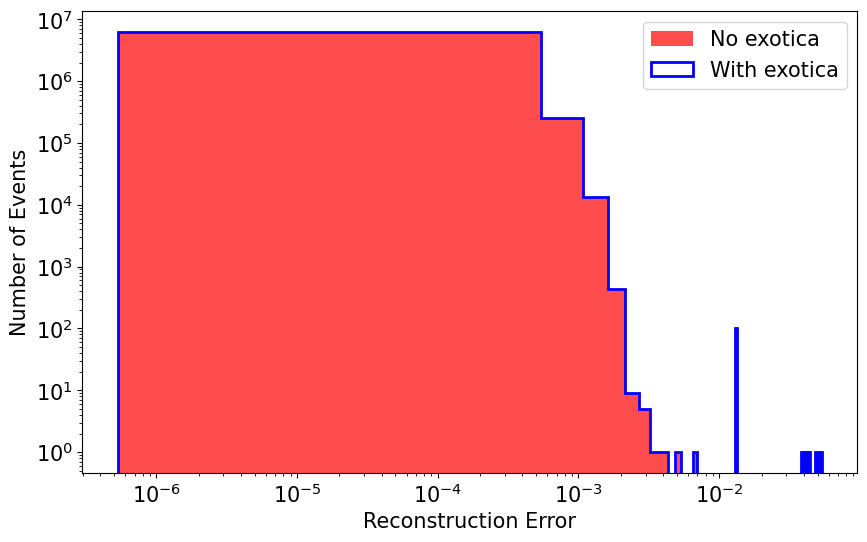

In [22]:
combined = np.concatenate([mse_alice_noexotica, mse_alice_exotica])

n_bins = 100

bin_edges = np.linspace(combined.min(), combined.max(), n_bins + 1)

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 15})
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
plt.hist(mse_alice_noexotica, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
plt.hist(mse_alice_exotica, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
#plt.title('Reconstruction Error Distribution for ALICE cocktail, w/ and w/o exotica')
#plt.ylim(0.01,10**8)
#plt.xlim(0.01,100)
plt.legend()

plt.savefig("final-error2.pdf")

# Show the plot
plt.show()

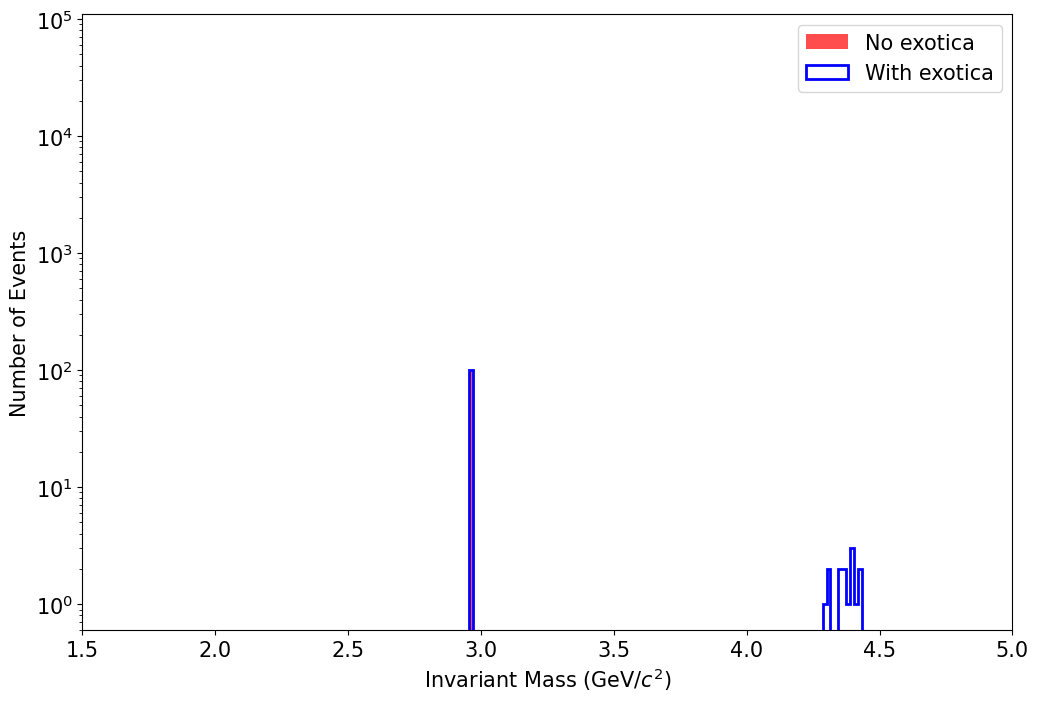

In [50]:
mse_threshold = 0.01

df_high_mse_noexotica = PID_noexotica_masscut[mse_alice_noexotica > mse_threshold]
alice_noexotica_masses = df_high_mse_noexotica['InvariantMass'].values

# Filter cocktail with exotica with reconstruction error above the threshold
df_high_mse_exotica = PID_exotica_masscut[mse_alice_exotica > mse_threshold]
alice_exotica_masses = df_high_mse_exotica['InvariantMass'].values

combined_masses = np.concatenate([alice_noexotica_masses, alice_exotica_masses])

n_bins = 100

bin_edges = np.linspace(combined_masses.min(), combined_masses.max(), n_bins + 1)

# Plot the invariant mass distribution
plt.figure(figsize=(12, 8))

plt.hist(alice_noexotica_masses, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
plt.hist(alice_exotica_masses, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

# Add labels and title
plt.xlabel(r'Invariant Mass (GeV/$c^2$)')
plt.ylabel('Number of Events')
plt.xlim(1.5,5)
#plt.ylim(0.1,100)
plt.yscale('log')
#plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold}')
plt.ylim(0.6,110000)
plt.legend()
plt.savefig("final-mass2.pdf")
# Show the plot
plt.show()

In [24]:

pq_count = np.sum((alice_exotica_masses >= 4) & (alice_exotica_masses <= 5))
print(pq_count)

number = np.sum((alice_exotica_masses >= 2.8) & (alice_exotica_masses <= 3.2))
print(number)

#np.sum((alice_exotica_masses >= 4) & (alice_exotica_masses <= 5))

14
100


In [25]:
# # Filter cocktail no exotica with reconstruction error above the threshold
# alice_noexotica_high_mse = df_all_shuffled_nopq_mass[mse_alice_noexotica > mse_threshold]
# alice_noexotica_masses = alice_noexotica_high_mse['InvariantMass'].values

# # Filter cocktail with exotica with reconstruction error above the threshold
# alice_exotica_high_mse = df_all_shuffled_mass[mse_alice_exotica > mse_threshold]
# alice_exotica_masses = alice_exotica_high_mse['InvariantMass'].values

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(alice_noexotica_masses, bins=100, alpha=0.7, label='ALICE without exotica', edgecolor = 'blue', color = 'none')
# plt.hist(alice_exotica_masses, bins=100, alpha=0.7, label='ALICE with exotica', color='red')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold}')
# plt.legend()

# # Show the plot
# plt.show()


In [26]:
# new_pq2 = new_df_all_2pq_shuffled[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
# # # Extract mass separately
# # mass = df['mass'].values
# mass_new_pq2 = new_df_all_2pq_shuffled['InvariantMass'].values

# new_pq2 = scaler.transform(new_pq2)

In [27]:
# new_df_all_2pq_shuffled

In [28]:
# new_pq2_pred = autoencoder.predict(new_pq2)
# mse_new_pq2 = np.mean(np.power(new_pq2 - new_pq2_pred, 2), axis=1)


In [29]:
# # Set the reconstruction error threshold
# mse_threshold = .01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# new_2pq_high_mse_indices = mse_new_pq2 > mse_threshold  # Boolean mask for filtering
# new_2pq_high_mse_masses = mass_new_pq2[new_2pq_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(new_2pq_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} with 2 pentaquarks')
# plt.legend()

# # Show the plot
# plt.show()


In [30]:
# new_2pq_high_mse_masses

In [31]:
# plt.figure(figsize=(10, 6))
# plt.xscale('log')  # Log scale for x-axis
# plt.yscale('log')  # Log scale for y-axis

# plt.hist(mse_new_pq2, bins=50, alpha=0.7, label='Normal Events', color='blue')

# plt.xlabel('Reconstruction Error')
# plt.ylabel('Number of Events')
# plt.title('Reconstruction Error Distribution for Normal and Anomalous Events with 2 Pentaquarks')
# plt.legend()

# # Show the plot
# plt.show()

In [32]:
# number_pqs_2 = np.sum((new_2pq_high_mse_masses >= 4) & (new_2pq_high_mse_masses <= 5))
# number_pqs_2


### Jpsi -> 4 pions sigma dfs

In [33]:
# new_df_all_jpsi4pi_sigma

In [34]:
# new_with_jpsi4pi = new_df_all_jpsi4pi_sigma[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values
# # # Extract mass separately
# # mass = df['mass'].values
# mass_new_with_jpsi_4pi = new_df_all_jpsi4pi_sigma['InvariantMass'].values

# new_with_jpsi4pi = scaler.transform(new_with_jpsi4pi)

In [35]:
# new_with_jpsi4pi

In [36]:
# new_with_jpsi4pi_pred = autoencoder.predict(new_with_jpsi4pi)
# mse_new_with_jpsi_4pi = np.mean(np.power(new_with_jpsi4pi - new_with_jpsi4pi_pred, 2), axis=1)

In [37]:
# # Set the reconstruction error threshold
# mse_threshold = .01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# new_with_jpsi_4pi_high_mse_indices = mse_new_with_jpsi_4pi > mse_threshold  # Boolean mask for filtering
# new_with_jpsi_4pi_high_mse_masses = mass_new_with_jpsi_4pi[new_with_jpsi_4pi_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(new_with_jpsi_4pi_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} with 2 pentaquarks')
# plt.legend()

# # Show the plot
# plt.show()


In [38]:
# jpsi4pi_sigma_filtered = new_df_jpsi4pi_sigma_filtered[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values

# mass_jpsi_4pi = new_df_jpsi4pi_sigma_filtered['InvariantMass'].values
# mass_jpsi_4pi

# jpsi4pi_sigma_filtered = scaler.transform(jpsi4pi_sigma_filtered)

In [39]:
# jpsi4pi_pred = autoencoder.predict(jpsi4pi_sigma_filtered)
# mse_jpsi_4pi = np.mean(np.power(jpsi4pi_sigma_filtered - jpsi4pi_pred, 2), axis=1)

In [40]:
# # Set the reconstruction error threshold
# mse_threshold = .01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# jpsi_4pi_high_mse_indices = mse_jpsi_4pi > mse_threshold  # Boolean mask for filtering
# jpsi_4pi_high_mse_masses = mass_jpsi_4pi[jpsi_4pi_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(jpsi_4pi_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} for Jpsi -> 4 pions')
# plt.legend()

# # Show the plot
# plt.show()


In [41]:
# new_df_all_jpsi3pi_sigma = pd.read_pickle("new_df_all_jpsi3pi_sigma.pkl")

# new_df_jpsi3pi_sigma_filtered = pd.read_pickle("new_df_jpsi3pi_sigma_filtered.pkl")
# new_df_jpsi3pi_sigma_filtered            

In [42]:
# jpsi3pi_all_sigma = new_df_all_jpsi3pi_sigma[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values

# mass_jpsi_3pi_all = new_df_all_jpsi3pi_sigma['InvariantMass'].values
# mass_jpsi_3pi_all

# jpsi3pi_all_sigma = scaler.transform(jpsi3pi_all_sigma)

In [43]:
# jpsi3pi_all_sigma_pred = autoencoder.predict(jpsi3pi_all_sigma)
# mse_jpsi_3pi_all_sigma = np.mean(np.power(jpsi3pi_all_sigma - jpsi3pi_all_sigma_pred, 2), axis=1)

In [44]:
# # Set the reconstruction error threshold
# mse_threshold = .01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# jpsi_3pi_all_high_mse_indices = mse_jpsi_3pi_all_sigma > mse_threshold  # Boolean mask for filtering
# jpsi_3pi_all_high_mse_masses = mass_jpsi_3pi_all[jpsi_3pi_all_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(jpsi_3pi_all_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} with Jpsi -> 3 pions')
# plt.legend()

# # Show the plot
# plt.show()


In [45]:
# jpsi3pi = new_df_jpsi3pi_sigma_filtered[['NTracks','NSigmaEl1','NSigmaMu1','NSigmaPi1','NSigmaKa1','NSigmaPr1','NSigmaEl2','NSigmaMu2','NSigmaPi2','NSigmaKa2','NSigmaPr2','NSigmaEl3','NSigmaMu3','NSigmaPi3','NSigmaKa3','NSigmaPr3','NSigmaEl4','NSigmaMu4','NSigmaPi4','NSigmaKa4','NSigmaPr4']].values

# mass_jpsi_3pi = new_df_jpsi3pi_sigma_filtered['InvariantMass'].values
# mass_jpsi_3pi

# jpsi3pi = scaler.transform(jpsi3pi)

In [46]:
# jpsi3pi_pred = autoencoder.predict(jpsi3pi)
# mse_jpsi_3pi = np.mean(np.power(jpsi3pi - jpsi3pi_pred, 2), axis=1)

In [47]:
# # Set the reconstruction error threshold
# mse_threshold = .01  # Adjust this value as needed

# # Filter test events with reconstruction error above the threshold
# jpsi_3pi_high_mse_indices = mse_jpsi_3pi > mse_threshold  # Boolean mask for filtering
# jpsi_3pi_high_mse_masses = mass_jpsi_3pi[jpsi_3pi_high_mse_indices]

# # Plot the invariant mass distribution
# plt.figure(figsize=(12, 8))

# plt.hist(jpsi_3pi_high_mse_masses, bins=50, alpha=0.7, label='Anomalous Test Events', color='blue')
# # plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
# # plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# # Add labels and title
# plt.xlabel('Invariant Mass')
# plt.ylabel('Number of Events')
# plt.yscale('log')
# plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold} for Jpsi -> 3 pions only')
# plt.legend()

# # Show the plot
# plt.show()


In [48]:
# jpsi_3pi_high_mse_masses